<a href="https://colab.research.google.com/github/CheshireCat12/Deep_learning_challenges/blob/master/CAE_with_FC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.nn import functional as F

from torch.autograd import Variable
from torch.utils.data import DataLoader

In [0]:
DOWNLOAD_DATASET = False
BATCH_SIZE = 64
NB_TEST_IMG = 5
NB_EPOCHS = 50
DEVICE= torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [0]:
norm_mean = [0.1307]
norm_std = [0.3081]

pre_process = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5, 0.5, 0.5),
                             std=(0.5, 0.5, 0.5))])

train_data = datasets.MNIST(root='./data',
                            train=True,
                            transform=pre_process,
                            download=True)
 
train_loader = DataLoader(train_data,
                          batch_size=BATCH_SIZE,
                          shuffle=True)

In [0]:
class ConvolutionAutoEncoder(nn.Module):
    
    def __init__(self):
        super(ConvolutionAutoEncoder, self).__init__()
        

        filters = [3, 32, 20]
        
        
        # (n + 2p - f)/s + 1
        self.encoder = nn.Sequential(
            nn.Conv2d(1, filters[0], kernel_size=3, stride=1, padding=1), # 32, 14, 14
            nn.ReLU(),
            nn.Conv2d(filters[0], filters[1], kernel_size=2, stride=2, padding=0), # 64, 7, 7
            nn.ReLU(),
            nn.Conv2d(filters[1], filters[1], kernel_size=3, stride=1, padding=1), # 128, 3, 3
            nn.ReLU(),
            nn.Conv2d(filters[1], filters[1], kernel_size=3, stride=1, padding=1), # 64, 7, 7
            nn.ReLU(),
        )
        
        self.fc = nn.Sequential(
            nn.Linear(filters[1]*14*14, 128),
            nn.ReLU(),
            nn.Linear(128, 20),
            nn.ReLU(),
            nn.Linear(20, 128),
            nn.ReLU(),
            nn.Linear(128, filters[1]*14*14),
            nn.ReLU()
        )

        # s(n-1)+f-2p
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(filters[1], filters[1], kernel_size=3, stride=1, padding=1), # 64, 7, 7
            nn.ReLU(),
            nn.ConvTranspose2d(filters[1], 16, kernel_size=3, stride=1, padding=1), # 16, 14, 14
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=2, stride=2, padding=0), # 1, 28, 28
            nn.ReLU(),
            #nn.Conv2d(filters[1], 1, kernel_size=3, stride=1, padding=1), # 16, 14, 14
            #nn.ReLU(),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        encoded = self.encoder(x)
        #print(encoded.size())
        # flat the image
        x = encoded.view(encoded.size(0), -1)
        #print(x.size())
        
        x = self.fc(x)
        
        #print(x.size())
        
        x = x.view(x.size(0), 32, 14, 14)
        
        #print(x.size())
        
        decoded = self.decoder(x)
        
        #print(decoded.size())
        
        return encoded, decoded

In [171]:
CAE = ConvolutionAutoEncoder()
CAE.to(DEVICE)
print(CAE)

def loss_function1(recon_x, x):
    # print(recon_x.size())
    # print(x.size())
    return F.binary_cross_entropy(recon_x.view(-1, 28*28),
                                    x.view(-1, 28*28), size_average=False)

#optimizer_cae = torch.optim.Adam(CAE.parameters(), weight_decay=1e-5)
# optimizer_cae = torch.optim.SGD(CAE.parameters(), lr=0.02, momentum=0.85)
optimizer_cae = torch.optim.RMSprop(CAE.parameters(), lr=1e-3)
loss_func_cae = nn.MSELoss()

view_data_cae = Variable(train_data.data[:NB_TEST_IMG].view(-1, 1, 28, 28).type(torch.cuda.FloatTensor))

ConvolutionAutoEncoder(
  (encoder): Sequential(
    (0): Conv2d(1, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(3, 32, kernel_size=(2, 2), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
  )
  (fc): Sequential(
    (0): Linear(in_features=6272, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=20, bias=True)
    (3): ReLU()
    (4): Linear(in_features=20, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=6272, bias=True)
    (7): ReLU()
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): ConvTranspose2d(16, 1, kernel_si

/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Epoch: 0/50 | Loss: -66884.5156


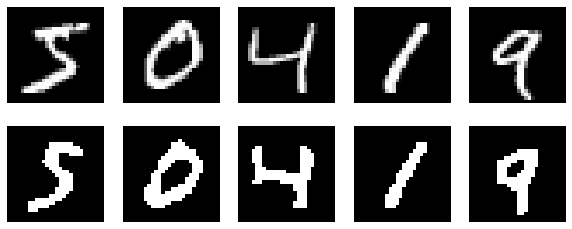

Epoch: 1/50 | Loss: -77744.9922
Epoch: 2/50 | Loss: -84971.4766
Epoch: 3/50 | Loss: -88694.2344
Epoch: 4/50 | Loss: -99098.3984
Epoch: 5/50 | Loss: -70506.9297
Epoch: 6/50 | Loss: -87835.2188
Epoch: 7/50 | Loss: -86224.2422
Epoch: 8/50 | Loss: -72331.0234
Epoch: 9/50 | Loss: -79880.0703
Epoch: 10/50 | Loss: -71071.2109


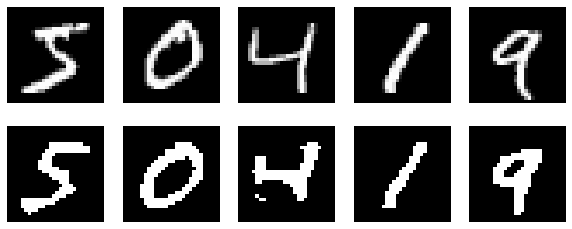

Epoch: 11/50 | Loss: -82139.2109
Epoch: 12/50 | Loss: -68202.5703
Epoch: 13/50 | Loss: -76129.6562
Epoch: 14/50 | Loss: -69360.0859
Epoch: 15/50 | Loss: -79559.8125
Epoch: 16/50 | Loss: -57240.1016
Epoch: 17/50 | Loss: -65735.2344
Epoch: 18/50 | Loss: -56027.8086
Epoch: 19/50 | Loss: -61797.9375
Epoch: 20/50 | Loss: -71227.5234


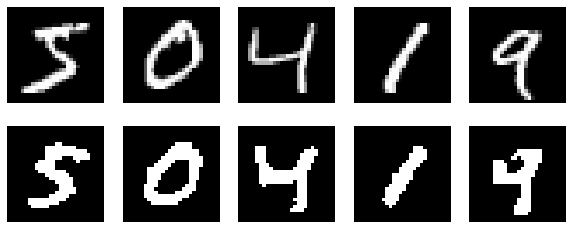

Epoch: 21/50 | Loss: -58120.1562
Epoch: 22/50 | Loss: -56547.3516
Epoch: 23/50 | Loss: -62227.6406
Epoch: 24/50 | Loss: -58375.2500
Epoch: 25/50 | Loss: -73768.6719
Epoch: 26/50 | Loss: -42777.3047
Epoch: 27/50 | Loss: -47815.6797
Epoch: 28/50 | Loss: -36700.1953
Epoch: 29/50 | Loss: -50050.8594
Epoch: 30/50 | Loss: -59150.8359


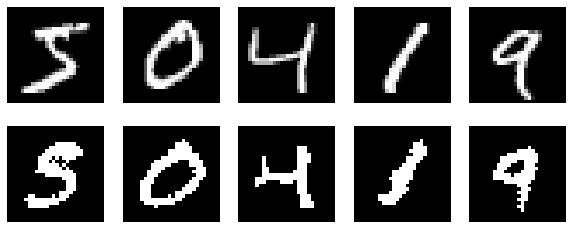

Epoch: 31/50 | Loss: -46321.6953
Epoch: 32/50 | Loss: -42755.8398
Epoch: 33/50 | Loss: -59979.2070
Epoch: 34/50 | Loss: -57591.8594
Epoch: 35/50 | Loss: -33870.2812
Epoch: 36/50 | Loss: -62280.0703
Epoch: 37/50 | Loss: -51013.4688
Epoch: 38/50 | Loss: -49135.0469
Epoch: 39/50 | Loss: -36501.5703
Epoch: 40/50 | Loss: -51633.6445


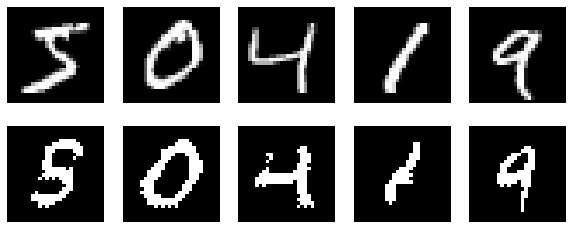

Epoch: 41/50 | Loss: -60778.2773
Epoch: 42/50 | Loss: -49905.0742
Epoch: 43/50 | Loss: -33586.9922
Epoch: 44/50 | Loss: -30744.1836
Epoch: 45/50 | Loss: -57824.3828
Epoch: 46/50 | Loss: -63156.2578
Epoch: 47/50 | Loss: -30016.0391
Epoch: 48/50 | Loss: -56995.8984
Epoch: 49/50 | Loss: -44579.6172


In [175]:
trainCAE(CAE, train_loader, view_data_cae, optimizer_cae)

In [0]:
def plot_img(model, view_data):
    _, decoded_data = model(view_data)  
    
    f, a = plt.subplots(2, NB_TEST_IMG, figsize=(10, 4))
    
    for i in range(NB_TEST_IMG):
        a[0][i].imshow(np.reshape(view_data.cpu().data.numpy()[i],
                                   (28, 28)),
                                   cmap='gray')
        a[0][i].set_xticks(())
        a[0][i].set_yticks(())
    
        
    for i in range(NB_TEST_IMG):
        a[1][i].imshow(np.reshape(decoded_data.cpu().data.numpy()[i],
                                   (28, 28)),
                                   cmap='gray')
        a[1][i].set_xticks(())
        a[1][i].set_yticks(())

    plt.show()
    

def trainCAE(model, data_loader, view_data, optimizer):
    for epoch in range(NB_EPOCHS):
        for x, _ in data_loader:
            x = Variable(x).to(DEVICE)
            y = Variable(x).to(DEVICE)
            
            # ===================forward=====================
            encoded, decoded = model(x)
            loss = loss_function1(decoded, y)
            # ===================backward=====================
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        print(f'Epoch: {epoch}/{NB_EPOCHS} | Loss: {loss.item():.4f}')
        
        if not epoch % 10:
            plot_img(model, view_data)

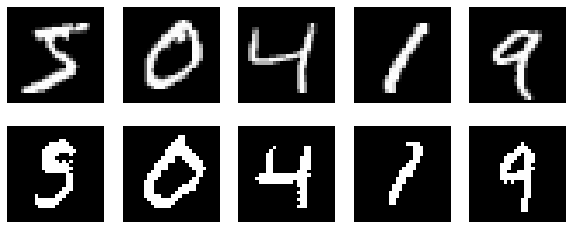

In [176]:
plot_img(CAE, view_data_cae)